In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from quetzal.io import excel
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.messaging as message
from biogeme import expressions as ex

In [3]:
model_path = '../model/' + scenario + '/'
input_path = '../input/'
zone_data_path = '../input_static/zones_Gebietsaenderungen/'
output_path = '../output/'

In [29]:
# Load parameters for settings
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

# Generation step: Trips per person

## Requires MiD data

## Saves generation volumes in zones

(Ortuzar 2011 [S. 166], Daly 1997): Define groups of individuals and determine for each group the number of trips per purpose.

Here the group of individuals is given by car availability and the urbanisation degree of the home zone. The deterimination of the number of trip per purpose is done by taking the mean value of number of reported trips per person in MiD2017. 

In [5]:
sm = stepmodel.read_json(model_path + 'de_zones')

### Load MiD data

In [6]:
# Load data on persons from MiD survey
cols = ['HP_ID_Reg', 'P_HOCH', 'P_GEW', 'P_RBW_ANZ', 'W_ANZWW', 'auto', 'VBGEM',
        'taet', # occupation types with NaN values
        'oek_status', # categories 1 (very low) to 5 (very high)
        'P_FKARTE', # ticket types with NaN values
        'hhgr_gr2', # 1, 2, 3, or 3+ persons in household
        'pkwdicht_krs' # 6 cats of car density in NUTS3 zone + NaN (95)
       ]
persons = pd.read_csv(input_path + 'transport_demand/MiD2017_Regional_Personen.csv',
                      sep=';', decimal=',', usecols=cols)
# Rename relevant columns
persons = persons[cols]
persons.columns = ['P_ID', 'P_HOCH', 'weight', 'work_trips', 'other_trips', 'car_av', 'origin',
                   'occupation', 'hh_income', 'pt_ticket', 'hh_size', 'car_dens']
persons.shape

(316361, 12)

In [7]:
# Add the number of trips by purpose
# Either the whole trips table
'''trips = pd.read_csv(input_path + 'transport_demand/MiD2017_Regional_Wege.csv',
                    sep=';', decimal=',', usecols=['HP_ID_Reg', 'hwzweck1']
                   ).rename(columns={'HP_ID_Reg': 'P_ID'})
purpose_mid_model_dict = {1: 'commuting', 2: 'business', 3: 'education',
                          4: 'buy/execute', 5: 'buy/execute', 6: 'leisure',
                          7: 'accompany', 99: 'leisure'}
trips['purpose_model'] = trips['hwzweck1'].map(purpose_mid_model_dict)'''
# Or take the filtered trips without very short ones
trips = pd.read_csv(input_path + 'transport_demand/calibration_all_trips_MiD2017.csv',
                    usecols=['P_ID', 'purpose_model'])
# Merge person informations with number of trips by purpose
trips = trips.groupby(['P_ID', 'purpose_model']).size().unstack('purpose_model').fillna(0).astype(int)
persons = persons.merge(trips, how='outer', left_on='P_ID', right_index=True)
persons.shape

(316361, 18)

In [8]:
# Total population of Germany in 2017 (million)
total_pop_MiD = persons['P_HOCH'].sum() / 1e6
total_pop_MiD

82.17568400000002

In [9]:
# Compare number of trips from persons table and trips table
# Take average values by person
# Filter persons with NaN values respectively
mask_persons = (persons['work_trips']<=50) & (persons['other_trips']<=50)
print('Average trips per day from persons table (n={}): {}'.format(
    len(persons.loc[mask_persons]),
    persons.loc[mask_persons, ['work_trips', 'other_trips']].sum(axis=1).mean()))
mask_trips = persons[list(trips.columns)].notna().all(axis=1)
av_total_trips_MiD = (persons.loc[mask_trips, list(trips.columns)].sum(axis=1) * persons['weight']).mean()
print('Average trips per day from trips table (n={}): {}'.format(
    len(persons.loc[mask_trips]), av_total_trips_MiD))

Average trips per day from persons table (n=410): 7.575609756097561
Average trips per day from trips table (n=115294): 2.0937696336061165


In [10]:
# Total trips per day from trips table (million)
# Full count, incl. very short trips: 260 mio.
total_pop_MiD * av_total_trips_MiD

172.05695178001204

In [12]:
purposes = list(trips.columns)

### Cleanse the data

In [13]:
# Translate origin zone keys in model zones
# Load official data sources that describe changes
# in ARS codes within one year (Gebietsänderungen)
col_names = ['n', 'level', 'old_ARS', 'old_AGS', 'old_name',
             'change', 'area', 'population', 'new_ARS', 'new_AGS',
             'new_name', 'date1', 'date2']
def update_ARS_until(end, ars):
    for year in range(2016, end+1):
        changes = pd.read_excel(zone_data_path + str(year) + '.xlsx',
                                sheet_name='Gebietsaenderungen {}'.format(year),
                                header=6, skipfooter=8, index_col=None,
                                names=col_names, na_filter=False)
        changes = changes.loc[(changes['level']=='Gemeindeverband')
                              & (changes['old_ARS']!=changes['new_ARS'])]
        changes['old_ARS'] = changes['old_ARS'].astype(int)
        changes['new_ARS'] = changes['new_ARS'].astype(int)
        update_dict = changes.set_index('old_ARS')['new_ARS'].to_dict()
        ars = ars.replace(update_dict)
    return ars
# Update LAU IDs and replace with model's zone IDs
lau_dict = sm.zones[['FID', 'ARS']].explode('ARS').set_index('ARS')['FID'].to_dict()
persons['origin'] = update_ARS_until(2021, persons['origin']).map(lau_dict)
# Merge population count and urb degree from model zones
persons = persons.merge(sm.zones[['population', 'urbanisation']], how='inner', # drop persons outside of model zones
                        left_on='origin', right_index=True)
persons.shape

(295993, 20)

In [14]:
# Drop relevant NaN data
persons = persons.loc[persons['car_av'].isin([0,1])]
persons = persons.loc[persons['occupation']!=9]
persons.shape

(295771, 20)

In [15]:
# Create different relevant occupations
persons['is_working'] = (persons['occupation']==1).astype(int)
persons['is_learning'] = (persons['occupation']==2).astype(int)
persons['is_caring'] = (persons['occupation']==3).astype(int)

In [16]:
# Create kardinal PT subscription categories
# Scale is the amount of perceived reduction for a ticket
persons['pt_ticket'] = persons['pt_ticket'].map(
    {1:0, 2:0.1, 3:0.2, 4:0.5, 5:0.9, 6:0, 7:0, 99:0, 200:0}
)

In [17]:
# Drop persons with missing choice variable
persons = persons.loc[persons[purposes].notna().all(axis=1)]
persons[purposes] = persons[purposes].astype(int)

In [18]:
# Divide number of trips by two, because half of them is the way back
for p in purposes:
    persons[p] = np.ceil(persons[p] / 2).astype(int)

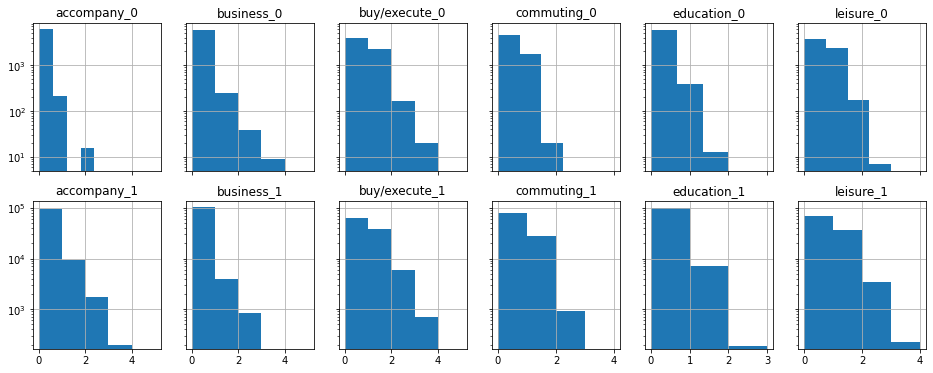

In [19]:
# Number of trips per demand segment
fig, ax = plt.subplots(nrows=2, ncols=len(purposes), figsize=(16,6),
                       sharex='col', sharey='row')
for i in range(len(purposes)):
    bins = int(persons[purposes[i]].max())
    for car in [0,1]:
        persons.loc[persons['car_av']==car, purposes[i]].hist(bins=bins, log=True, ax=ax[car,i])
        ax[car,i].set_title(purposes[i]+'_'+str(car))

## Build a choice model

Choice variable is the number of trips. The model is segmented in
* population segments: car availability in household
* trip purposes

$V=ASC_0+log(\text{pop})*\beta^{pop}+\text{hh size}*\beta^{size}+\text{hh income}*\beta^{in}+\text{is working}*\beta^{work}+\text{is learning}*\beta^{learn}+\text{is caring}*\beta^{care}+\text{pt ticket}*\beta^{ticket}$

In [20]:
# decide whether to estimate new parameters or use saved ones
estimate_anew = False

In [21]:
# Result containers
betas = pd.DataFrame()
t_tests = pd.DataFrame()
general = pd.DataFrame()
# Save utility functions for later
Vs = {}

# Number of choices = max_trips-1 (because of 0 trips)
max_trips = 6

car_names = {0: '_no_car', 1: '_car'}
for car in [0,1]:
    # create a database for this population segment
    database = db.Database(car_names[car][1:],
                           persons.loc[persons['car_av']==car].drop('origin', axis=1).copy())
    globals().update(database.variables)
    Vs[car] = {}
    
    # Define parameters
    for p in purposes:
        ASC = {0: ex.Beta('ASC_0', 0, None, None, 0)} # The only free one
        ASC.update({j: ex.Beta('ASC_'+str(j), 0, None, None, 1) for j in range(1, max_trips)})
        b_pop = {j: ex.Beta('b_pop_'+str(j), 0, None, None, 0) for j in range(max_trips)}
        b_size = {j: ex.Beta('b_size_'+str(j), 0, None, None, 0) for j in range(max_trips)}
        b_in = {j: ex.Beta('b_in_'+str(j), 0, None, None, 0) for j in range(max_trips)}
        b_work = {j: ex.Beta('b_work_'+str(j), 0, None, None, 0) for j in range(max_trips)}
        b_learn = {j: ex.Beta('b_learn_'+str(j), 0, None, None, 0) for j in range(max_trips)}
        b_care = {j: ex.Beta('b_care_'+str(j), 0, None, None, 0) for j in range(max_trips)}
        b_ticket = {j: ex.Beta('b_ticket_'+str(j), 0, None, None, 0) for j in range(max_trips)}
    
    # Define the utility formulation by purpose
    Vs[car]['commuting'] = {j:
         ASC[j]
         + ex.log(1+population)*b_pop[j]
         #+ hh_size * b_size[j]
         + hh_income * b_in[j]
         + is_working * b_work[j]
         + pt_ticket * b_ticket[j]
         for j in range(max_trips)}
    Vs[car]['business'] = {j:
         ASC[j]
         + ex.log(1+population)*b_pop[j]
         + hh_size * b_size[j]
         + hh_income * b_in[j]
         + is_working * b_work[j]
         + is_learning * b_learn[j]
         + is_caring * b_care[j]
         + pt_ticket * b_ticket[j]
         for j in range(max_trips)}
    Vs[car]['education'] = {j:
         ASC[j]
         + ex.log(1+population)*b_pop[j]
         + hh_size * b_size[j]
         + hh_income * b_in[j]
         + is_learning * b_learn[j]
         + pt_ticket * b_ticket[j]
         for j in range(max_trips)}
    Vs[car]['buy/execute'] = {j:
         ASC[j]
         + ex.log(1+population)*b_pop[j]
         + hh_size * b_size[j]
         + hh_income * b_in[j]
         #+ is_working * b_work[j]
         #+ is_learning * b_learn[j]
         #+ is_caring * b_care[j]
         #+ pt_ticket * b_ticket[j]
         for j in range(max_trips)}
    Vs[car]['leisure'] = {j:
         ASC[j]
         + ex.log(1+population)*b_pop[j]
         + hh_size * b_size[j]
         + hh_income * b_in[j]
         + is_working * b_work[j]
         + is_learning * b_learn[j]
         + is_caring * b_care[j]
         #+ pt_ticket * b_ticket[j]
         for j in range(max_trips)}
    Vs[car]['accompany'] = {j:
         ASC[j]
         + ex.log(1+population)*b_pop[j]
         + hh_size * b_size[j]
         + hh_income * b_in[j]
         + is_learning * b_learn[j]
         + is_caring * b_care[j]
         + pt_ticket * b_ticket[j]
         for j in range(max_trips)}

    for p in purposes:
        # Remove observations with more trips than the maximum
        database.remove(globals()[p] >= max_trips)
        
        # Run the estimation
        logprob = models.loglogit(Vs[car][p], None, globals()[p])
        formulas = {'loglike': logprob, 'weight': weight} # give weights to the estimator
        model = bio.BIOGEME(database, formulas)
        model.modelName = p + car_names[car]
        model.generateHtml = False
        model.generatePickle = False
        if estimate_anew: results = model.estimate()
        
        # Save results
        if estimate_anew:
            betas[model.modelName] = results.getEstimatedParameters()['Value']
            t_tests[model.modelName] = np.abs(results.getEstimatedParameters()['Rob. t-test'])

In [22]:
# Save or load results
if estimate_anew:
    betas.to_csv(input_path + 'generation_betas.csv')
    t_tests.to_csv(input_path + 'generation_t_tests.csv')
else:
    betas = pd.read_csv(input_path + 'generation_betas.csv', index_col=0)
    t_tests = pd.read_csv(input_path + 'generation_t_tests.csv', index_col=0)

In [23]:
np.round(betas, 3)

,accompany_no_car,business_no_car,buy/execute_no_car,commuting_no_car,education_no_car,leisure_no_car,accompany_car,business_car,buy/execute_car,commuting_car,education_car,leisure_car
ASC_0,6.452,5.667,-0.782,2.886,5.249,1.644,4.815,6.484,-1.284,3.323,5.309,1.855
b_care_0,2.826,10.431,NaN,NaN,NaN,0.553,-0.344,0.570,NaN,NaN,NaN,0.577
b_care_1,3.563,-8.961,NaN,NaN,NaN,0.708,-0.195,-0.024,NaN,NaN,NaN,0.458
b_care_2,-5.331,-1.051,NaN,NaN,NaN,-1.086,-0.308,1.538,NaN,NaN,NaN,0.388
b_care_3,-0.998,-0.261,NaN,NaN,NaN,-0.162,0.762,-1.030,NaN,NaN,NaN,0.641
b_care_4,-0.030,-0.032,NaN,NaN,NaN,-0.007,0.244,-0.889,NaN,NaN,NaN,-2.054
b_care_5,-0.030,-0.127,NaN,NaN,NaN,-0.007,-0.159,-0.165,NaN,NaN,NaN,-0.010
b_in_0,-0.580,-1.089,0.244,0.402,-0.001,0.119,-0.479,-0.375,0.169,0.071,-0.079,0.122
b_in_1,-0.682,-1.240,0.080,0.457,-0.359,0.235,-0.524,-0.245,0.077,0.012,-0.152,0.248
b_in_2,-1.004,-0.883,-0.187,0.113,-0.258,0.187,-0.671,-0.399,0.024,-0.050,-0.320,0.156


In [24]:
np.round(t_tests, 2)

,accompany_no_car,business_no_car,buy/execute_no_car,commuting_no_car,education_no_car,leisure_no_car,accompany_car,business_car,buy/execute_car,commuting_car,education_car,leisure_car
ASC_0,13.68,12.42,4.41,12.61,13.32,9.41,50.18,40.48,20.69,43.87,40.15,30.24
b_care_0,18.80,45.65,NaN,NaN,NaN,2.68,0.77,2.18,NaN,NaN,NaN,7.51
b_care_1,18.00,36.86,NaN,NaN,NaN,3.35,0.44,0.07,NaN,NaN,NaN,5.82
b_care_2,18.86,3.11,NaN,NaN,NaN,1.40,0.68,4.16,NaN,NaN,NaN,3.49
b_care_3,1.84,0.43,NaN,NaN,NaN,0.43,1.62,0.93,NaN,NaN,NaN,2.28
b_care_4,0.20,906.50,NaN,NaN,NaN,0.03,0.46,2.58,NaN,NaN,NaN,8.71
b_care_5,0.20,1845.33,NaN,NaN,NaN,0.03,0.07,0.26,NaN,NaN,NaN,0.13
b_in_0,11.23,15.95,6.58,2.34,0.05,3.68,5.28,9.18,1.33,1.98,2.80,3.31
b_in_1,10.96,15.64,2.14,2.65,8.64,6.98,5.76,5.52,0.60,0.34,5.22,6.70
b_in_2,7.77,6.69,3.13,0.45,2.90,3.04,7.24,7.33,0.19,1.07,5.24,3.90


## Calculate generation volumes in model zones

In [25]:
sm.zones['population'].sum() / 1e6

83.146029

In [26]:
# Construct a database with one entry per zone
# for simulation of trip generation probabilities
# First, generate a NUTS1-level in persons table to get means by Bundesland
persons['NUTS1'] = persons['origin'].str[:3]
# Compute means by model zones' urbanisation degree
sim_zones = [pd.DataFrame()]
for u in persons['urbanisation'].unique():
    p_grouped = persons.loc[persons['urbanisation']==u].groupby('NUTS1')
    assert p_grouped.size().min() > 50, 'The sample size is not representative in at least one region'
    mask = sm.zones['urbanisation']==u
    sim_zones.append(pd.DataFrame(index=sm.zones.loc[mask].index,
                                  data={
        'population': sm.zones.loc[mask, 'population'],
        'hh_size': sm.zones.loc[mask, 'NUTS_ID'].str[:3].map(p_grouped['hh_size'].mean()),
        'hh_income': sm.zones.loc[mask, 'NUTS_ID'].str[:3].map(p_grouped['hh_income'].mean()),
        'is_working': sm.zones.loc[mask, 'NUTS_ID'].str[:3].map(p_grouped['is_working'].mean()),
        'is_learning': sm.zones.loc[mask, 'NUTS_ID'].str[:3].map(p_grouped['is_learning'].mean()),
        'is_caring': sm.zones.loc[mask, 'NUTS_ID'].str[:3].map(p_grouped['is_caring'].mean()),
        'pt_ticket': sm.zones.loc[mask, 'NUTS_ID'].str[:3].map(p_grouped['pt_ticket'].mean())
    }))
sim_zones = pd.concat(sim_zones)

In [27]:
# Simulate the probabilities and put them into the zones table
zones_db = db.Database('zones', sim_zones)
for p in purposes:
    for car in [0,1]:
        simulate = {j: models.logit(Vs[car][p], None, j) for j in range(max_trips)}
        model = bio.BIOGEME(zones_db, simulate)
        probs = model.simulate(theBetaValues=betas[p+car_names[car]].to_dict())
        
        # Calculate generation volumes
        trips_here = 1 * probs[1] + 2 * probs[2] + 3 * probs[3] + 4 * probs[4] + 5 * probs[5]
        print('{}_{}: {} trips p.p.'.format(p,car,np.round(trips_here.mean(), 2)))
        sm.zones[str((p+car_names[car], 'generation'))] = trips_here * sm.zones['population'] * 365

accompany_0: 0.05 trips p.p.
accompany_1: 0.12 trips p.p.
business_0: 0.01 trips p.p.
business_1: 0.01 trips p.p.
buy/execute_0: 0.34 trips p.p.
buy/execute_1: 0.49 trips p.p.
commuting_0: 0.06 trips p.p.
commuting_1: 0.05 trips p.p.
education_0: 0.02 trips p.p.
education_1: 0.03 trips p.p.
leisure_0: 0.43 trips p.p.
leisure_1: 0.45 trips p.p.


In [31]:
# Sum of trips per day with model population (million)
sm.zones[[str((p+car_names[c], 'generation')) for p in purposes for c in [0,1]]
        ].sum().sum() / 1e6 / 365

170.00337643647055

### Influence levers

Modify generation volumes for future scenarios

In [30]:
# Remote work from home
for car in [0,1]:
    sm.zones[str(('commuting'+car_names[car], 'generation'))] *= 1 - params['generation']['remote_work_share']

## Save results in zones table

In [32]:
sm.to_json(model_path + 'de_zones', only_attributes=['zones'])

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.80it/s]
